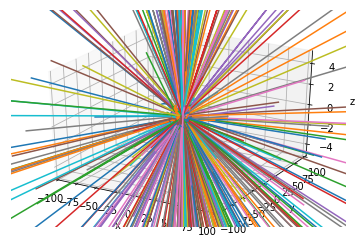

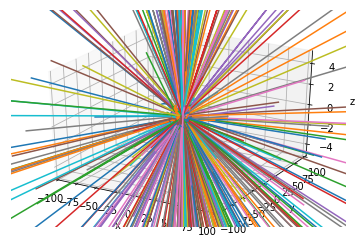

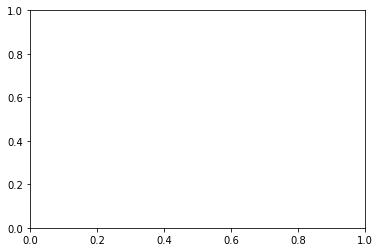

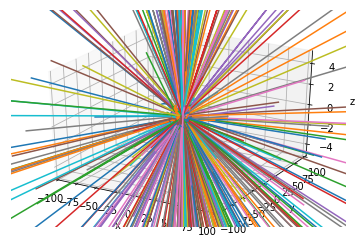

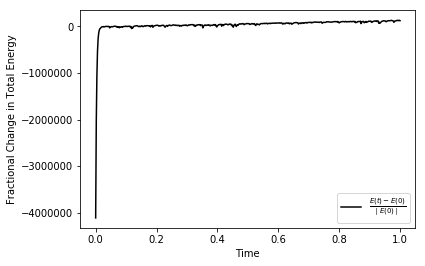

In [25]:
# By Kris Laferriere, Claire Hinrichs, Matt Wilkin
# 12/4/19
# Based off of a program written by Kris Laferriere, Vivian Carvajal, and Ben Flaggs for ASTR415
# This code uses initial conditions from a data file and integrates the system using second-order Leapfrog (LF2), and
# ensures that energy is conserved.

# ----------------------------------------------------------------
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.colors
import matplotlib as mpl

# Functions
# ----------------------------------------------------


def collisions(N, p, epsilon_0, mass_arr, vnew, pos):
    """ This function works to determine if particles are colliding, defining a collision as particles within an epsilon
     value set at the beginning of the main code. It removed the rows for which a particle has a mass set to be zero.
     Values
     ----
     N: [500, 1] number of particles
     p: [1] the specific particle number
     epsilon_0: [1], defined as the diameter of a particle (such that if two particles are within one radius,
     they are colliding). A physical size for this (if assuming dust particles) is a few microns, and if we are doing
     a dust could our masses are 10^-7 grams (oof!).
     dist: [500, 3], value from gravity2, the distance between particle p and every other particle
     mass_arr: [500, 1], the array of masses for each particle
     vnew: [500, 3], the array of new velocities, carrying the original velocities for particles that did not collide at
     this time step, and the new values for particles that did collide at this time step (calculated using momentum
     conservation).
    """

    dist = pos[p] - pos     # Calculates distance between particle p and all others
    coll = np.array([particle for particle in range(N) if (np.sqrt(dist[particle, 0] ** 2 + dist[particle, 1] ** 2
                                                            + dist[particle, 2] ** 2) <= epsilon_0)])
    # Determining if a collision happens
    if np.size(coll) >= 2:
        # doing the collision
        if mass_arr[coll[0]] > mass_arr[coll[1]] and mass_arr[coll[0]] > 0:
            vnew[coll[0]] = (mass_arr[coll[0]]*vnew[coll[0]] + mass_arr[coll[1]]*vnew[coll[1]])/(mass_arr[coll[0]]
                                                                                                 + mass_arr[coll[1]])
            mass_arr[coll[0]] += mass_arr[coll[1]]
            mass_arr[coll[1]] = 0
            vnew[coll[1]] = 0
        elif mass_arr[coll[0]] == 0 and mass_arr[coll[1]] == 0:
            vnew[coll[0]] = 0
            vnew[coll[1]] = 0
        else:
            vnew[coll[1]] = (mass_arr[coll[0]]*vnew[coll[0]] + mass_arr[coll[1]]*vnew[coll[1]])/(mass_arr[coll[0]]
                                                                                                 + mass_arr[coll[1]])
            mass_arr[coll[1]] += mass_arr[coll[0]]
            mass_arr[coll[0]] = 0
            vnew[coll[0]] = 0

    size_p = np.shape(pos)[0]
    return vnew, mass_arr, pos, size_p


def derivatives(n_particle, position, velocity, epsilon, mass_a, soften):
    """ This function outputs derivative information using the function gravity2"""

    v_dot, velocity, m = gravity2(n_particle, position[:, 0:3], epsilon, mass_a, soften, velocity)
    out = np.array([m, velocity[:, 0], velocity[:, 1], velocity[:, 2], v_dot[:, 0], v_dot[:, 1], v_dot[:, 2]])
    return np.transpose(out)


def gravity2(Np, pos_arr, epsilon_0, mass_arr, softening, velocity):
    """ Gravity function to calculate the accelerations. Checks the distance between the particles, and if it is less
    than the epsilon value, make it a collision. Output the acceleration for each particle. """

    N_new = np.size(mass_arr)
    acc = np.zeros(pos_arr.shape)
    for i in range(Np):
        # Calculating collisions and gravitational accel.
        velocity, mass_arr, pos_arr, N_new = collisions(N_new, i, epsilon_0, mass_arr, velocity, pos_arr)
        rs = pos_arr[i] - pos_arr
        r2 = (rs ** 2).sum(axis=1) + softening**2
        ir3 = -1 * np.divide(mass_arr * np.ones_like(r2), np.sqrt(r2) * r2, out=np.zeros_like(r2), where=r2 != 0)
        acc[i, :] = (ir3[:, np.newaxis] * rs).sum(axis=0)

    return acc, velocity, mass_arr


def leapfrog(func, values, dt, time, Np, particle_mass, epsilon, soften):
    """ Leapfrog integrator. """

    froggy = np.zeros(shape=(Np, 7, time))
    froggy[:, 1:7, 0] = values[:, 0:6]
    froggy[:, 0, 0] = particle_mass[:]
    count = 1
    for t in range(1, time):
        froggy[:, 0, t] = particle_mass[:]
        half = froggy[:, 1:4, t - 1] + 0.5 * dt * froggy[:, 4:7, t - 1]
        froggy[:, 4:7, t] = froggy[:, 4:7, t - 1] + dt * func(Np, half, froggy[:, 4:7, t - 1], epsilon, particle_mass,
                                                              soften)[:, 4:7]
        froggy[:, 1:4, t] = half + 0.5 * dt * froggy[:, 4:7, t]

        Epoints = []
        if t % frequency == 0:
            ke = 0.0
            pe = 0.0
            for i in range(N):
                ke += 0.5 * mass_array[i] * (np.linalg.norm(velocity_array[i]))**2
                rs = pos_array[i] - pos_array
                r2 = (rs**2).sum(axis=1) + epsilon
                pei = - np.divide(mass_array * np.ones_like(r2), np.sqrt(r2),
                           out=np.zeros_like(r2), where=r2 != epsilon)
                pe += mass_array[i] * pei.sum()
                pe = pe / 2  # adjust for double counting
                E = pe + ke
                Epoints.append(E)
            
            count = count + 1
            np.savetxt('n_body_%05d.txt' % t, froggy[:, :, t])

            fig = plt.figure()
            ax = fig.add_subplot(111, projection='3d')
            p = ax.scatter(froggy[:, 1, t], froggy[:, 2, t], froggy[:, 3, t], '.', c=particle_mass) #, norm=mpl.colors.Normalize(vmin=0, vmax=10))
                           # norm=matplotlib.colors.LogNorm())
            fig.colorbar(p, ax=ax)
            ax.set_zlim(-15, 15)
            ax.set_xlim(-200, 200)
            ax.set_ylim(-200, 200)
            plt.title('N-Body Simulation of 500 Particles in a Disk')
            ax.set_xlabel('x')
            ax.set_ylabel('y')
            ax.set_zlabel('z')
            plt.savefig("n_body_%05d.png" % count)
            plt.close(fig)

    return froggy


if __name__ == "__main__":
    # Parameters
    epsilon = 0.1          # distance at which particles are considered to be colliding
    soft = 0.1          # the softening parameter
    frequency = 10      # how many steps occur between plot output
    h = 0.01            # the size of steps
    n = 100            # the number of steps

    # Read in the data
    filename = "data_Nparticles.txt"
    mass, r, phi, z, r_dot, w, z_dot = np.loadtxt(filename, unpack=True)

    # Transform to cartesian coordinates.
    x = r*np.cos(phi)
    y = r*np.sin(phi)
    x_dot = r_dot*np.cos(phi) - r*w*np.sin(phi)
    y_dot = r_dot*np.sin(phi) + r*w*np.cos(phi)

    # Define the mass, position, velocity arrays
    mass_array = mass
    pos_array = np.transpose(np.array([x, y, z]))
    velocity_array = np.transpose(np.array([x_dot, y_dot, z_dot]))
    a = np.transpose(np.array([x, y, z, x_dot, y_dot, z_dot]))
    N = len(mass)

    # Integrate over time
    trial = leapfrog(derivatives, a, h, n, N, mass_array, epsilon, soft)

    # Plot and save the final product, will be ugly
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    
    for j in range(0, N):
        if trial[j, 0, 49] != 0:
            ax.plot(trial[j, 1, :], trial[j, 2, :], trial[j, 3, :], '-', label='Particle %f' % j)

    ax.set_zlim(-5, 5)
    ax.set_xlim(-100, 100)
    ax.set_ylim(-100, 100)

    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')

    #Energy Calc
    
    '''   
    Epoints = []
    if n % frequency == 0:
        ke = 0.0
        pe = 0.0
        for i in range(N):
            ke += 0.5 * mass_array[i] * (np.linalg.norm(velocity_array[i]))**2
            rs = pos_array[i] - pos_array
            r2 = (rs**2).sum(axis=1) + epsilon
            pei = - np.divide(mass_array * np.ones_like(r2), np.sqrt(r2),
                           out=np.zeros_like(r2), where=r2 != epsilon)
            pe += mass_array[i] * pei.sum()
            pe = pe / 2  # adjust for double counting
            E = pe + ke
            Epoints.append(E)
            #frac_E = np.divide((Epoints[i] - Epoints[0]), np.absolute(Epoints[0]))

    print(Epoints)
    #print(frac_E)
    '''
    # need to find this equation in the old homework handout
    #frac_E = np.divide((E[:] - E_0[:]), np.absolute(E_0[:]))

    # Define the time that the system is integrated over
    time = np.linspace(0, h * n, np.size(Epoints, 0))

    # Plot the fractional change in total energy vs. time for this system
            
    plt.figure()
    plt.plot(time, Epoints, 'k-', label=r'$\frac{E(t) - E(0)}{\mid E(0) \mid}$')
    plt.xlabel('Time')
    plt.ylabel('Fractional Change in Total Energy')
    plt.legend()
    plt.savefig('energy.png')
    plt.show()
